# Linear mixed effects model
## Random effects on intercept and slope with covariance matrix

In [1]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import numpy as np

import patsy
import pystan
print(pystan.__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

2.17.1.0


In [2]:
SEED = 123
DRAWS = 5000
BURNIN = 2000
CHAINS = 4

In [3]:
sleep = pd.read_csv('../datasets/sleepstudy.csv', index_col=0)
sleep['Subject'] = pd.Categorical(sleep['Subject'], ordered=False)
sleep.head()

,Reaction,Days,Subject
1,249.5600,0,308
2,258.7047,1,308
3,250.8006,2,308
4,321.4398,3,308
5,356.8519,4,308


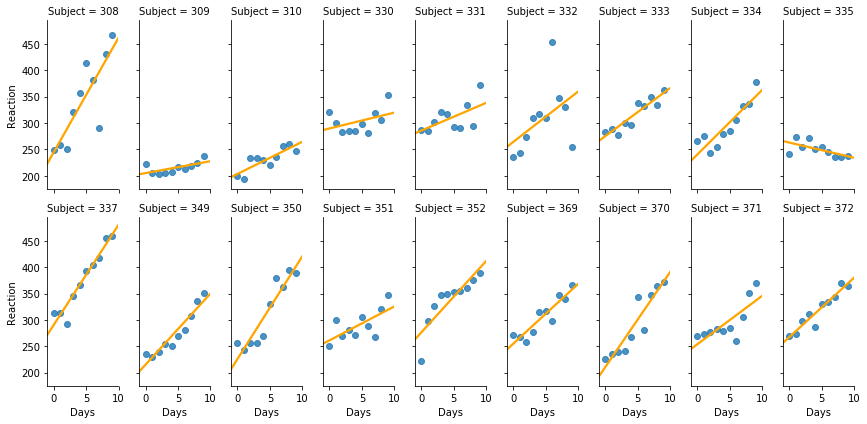

In [4]:
sns.lmplot(x="Days", y="Reaction", col="Subject", data=sleep, ci=None, line_kws={'color':'orange'}, col_wrap=9, palette="muted", aspect=0.45, size=3)

In [5]:
X = patsy.dmatrix("1 + Days", data=sleep, return_type='dataframe')
X = np.asarray(X)
X.shape

(180, 2)

In [6]:
Z_intercept = patsy.dmatrix('0 + Subject', data=sleep, return_type='dataframe')
Z_intercept = np.asarray(Z_intercept)

Z_slope = patsy.dmatrix('0 + Subject:Days', data=sleep, return_type='dataframe')
Z_slope = np.asarray(Z_slope)

Z_intercept.shape

(180, 18)

In [7]:
Z = np.concatenate((Z_intercept, Z_slope), axis=1)
Z.shape

(180, 36)

In [8]:
Y = np.asarray(sleep['Reaction'])
Y.shape

(180,)

In [9]:
stan_code = r""" 
// generated with brms 2.3.0
functions { 
} 
data { 
  int<lower=1> N;  // total number of observations 
  vector[N] Y;  // response variable 
  int<lower=1> K;  // number of population-level effects 
  matrix[N, K] X;  // population-level design matrix 
  // data for group-level effects of ID 1
  int<lower=1> J_1[N];
  int<lower=1> N_1;
  int<lower=1> M_1;
  vector[N] Z_1_1;
  vector[N] Z_1_2;
  int<lower=1> NC_1;
  int prior_only;  // should the likelihood be ignored? 
} 
transformed data { 
  int Kc = K - 1; 
  matrix[N, K - 1] Xc;  // centered version of X 
  vector[K - 1] means_X;  // column means of X before centering 
  for (i in 2:K) { 
    means_X[i - 1] = mean(X[, i]); 
    Xc[, i - 1] = X[, i] - means_X[i - 1]; 
  } 
} 
parameters { 
  vector[Kc] b;  // population-level effects 
  real temp_Intercept;  // temporary intercept 
  real<lower=0> sigma;  // residual SD 
  vector<lower=0>[M_1] sd_1;  // group-level standard deviations
  matrix[M_1, N_1] z_1;  // unscaled group-level effects
  // cholesky factor of correlation matrix
  cholesky_factor_corr[M_1] L_1;
} 
transformed parameters { 
  // group-level effects 
  matrix[N_1, M_1] r_1 = (diag_pre_multiply(sd_1, L_1) * z_1)';
  vector[N_1] r_1_1 = r_1[, 1];
  vector[N_1] r_1_2 = r_1[, 2];
} 
model { 
  vector[N] mu = Xc * b + temp_Intercept; 
  for (n in 1:N) { 
    mu[n] += r_1_1[J_1[n]] * Z_1_1[n] + r_1_2[J_1[n]] * Z_1_2[n];
  } 
  // priors including all constants 
  target += student_t_lpdf(temp_Intercept | 3, 289, 59); 
  target += student_t_lpdf(sigma | 3, 0, 59)
    - 1 * student_t_lccdf(0 | 3, 0, 59); 
  target += student_t_lpdf(sd_1 | 3, 0, 59)
    - 2 * student_t_lccdf(0 | 3, 0, 59); 
  target += normal_lpdf(to_vector(z_1) | 0, 1);
  target += lkj_corr_cholesky_lpdf(L_1 | 1); 
  // likelihood including all constants 
  if (!prior_only) { 
    target += normal_lpdf(Y | mu, sigma); 
  } 
} 
generated quantities { 
  // actual population-level intercept 
  real b_Intercept = temp_Intercept - dot_product(means_X, b); 
  corr_matrix[M_1] Cor_1 = multiply_lower_tri_self_transpose(L_1);
  vector<lower=-1,upper=1>[NC_1] cor_1;
  // take only relevant parts of correlation matrix
  cor_1[1] = Cor_1[1,2]; 
} 
"""

In [10]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bbac9240aa4ec7143d0292fe6d07bad5 NOW.


In [11]:
stan_data = {
    'N': Y.shape[0], # n. observations
    'Y': Y, # observations
    'K': X.shape[1], # n. fixed effects
    'X': X, # fixed effect design matrix
    'J_1': sleep.Subject.cat.codes.values + 1, # index to map each observation to the right subject
    'N_1': Z_intercept.shape[1], # n. subjects
    'M_1': X.shape[1], # n. fixed effects
    'Z_1_1': Z_intercept.sum(axis=1), # basically a vector of 1s
    'Z_1_2': Z_slope.sum(axis=1), # basically a vector repeating 0:9
    'NC_1': X.shape[1] - 1, # the number of correlation coefficients
    'prior_only':0
}

In [12]:
stan_data

{'N': 180,
 'Y': array([249.56  , 258.7047, 250.8006, 321.4398, 356.8519, 414.6901,
        382.2038, 290.1486, 430.5853, 466.3535, 222.7339, 205.2658,
        202.9778, 204.707 , 207.7161, 215.9618, 213.6303, 217.7272,
        224.2957, 237.3142, 199.0539, 194.3322, 234.32  , 232.8416,
        229.3074, 220.4579, 235.4208, 255.7511, 261.0125, 247.5153,
        321.5426, 300.4002, 283.8565, 285.133 , 285.7973, 297.5855,
        280.2396, 318.2613, 305.3495, 354.0487, 287.6079, 285.    ,
        301.8206, 320.1153, 316.2773, 293.3187, 290.075 , 334.8177,
        293.7469, 371.5811, 234.8606, 242.8118, 272.9613, 309.7688,
        317.4629, 309.9976, 454.1619, 346.8311, 330.3003, 253.8644,
        283.8424, 289.555 , 276.7693, 299.8097, 297.171 , 338.1665,
        332.0265, 348.8399, 333.36  , 362.0428, 265.4731, 276.2012,
        243.3647, 254.6723, 279.0244, 284.1912, 305.5248, 331.5229,
        335.7469, 377.299 , 241.6083, 273.9472, 254.4907, 270.8021,
        251.4519, 254.6362, 245.

In [13]:
stan_fit = stan_model.sampling(data=stan_data, chains=4, iter=DRAWS+BURNIN, warmup=BURNIN, seed=SEED, control={'adapt_delta':0.95})

d:\dev\pystan\pystan\misc.py:357: RuntimeWarning: invalid value encountered in sqrt
  sem=msd[:, 1] / np.sqrt(ess), ess=ess, rhat=rhat,


In [14]:
print(stan_fit)

Inference for Stan model: anon_model_bbac9240aa4ec7143d0292fe6d07bad5.
4 chains, each with iter=7000; warmup=2000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]            10.39    0.02   1.71   7.04   9.29   10.4   11.5  13.76   9996    1.0
temp_Intercept 297.98     0.1   9.89 278.29 291.58 298.05 304.32 317.69   9763    1.0
sigma           25.92    0.01   1.56  23.08  24.84  25.83  26.93  29.22  19861    1.0
sd_1[1]         26.84    0.07   6.78  15.63  22.11  26.07  30.88  42.26  10244    1.0
sd_1[2]          6.56    0.02   1.53   4.16   5.49   6.35   7.41  10.09   8789    1.0
z_1[1,1]         0.12  4.2e-3   0.55  -0.98  -0.24   0.11   0.48   1.24  17842    1.0
z_1[2,1]         1.47  4.1e-3   0.55   0.41   1.11   1.46   1.82   2.57  17995    1.0
z_1[1,2]        -1.53  4.3e-3   0.57  -2.69   -1.9  -1.52  -1.15  -0.46  17556    1.0
z_1[2,2]        -1.26  6.3e-3   0.66

d:\dev\pystan\pystan\misc.py:357: RuntimeWarning: invalid value encountered in sqrt
  sem=msd[:, 1] / np.sqrt(ess), ess=ess, rhat=rhat,


In [15]:
trace = stan_fit.extract(permuted=True)

In [16]:
trace

OrderedDict([('b',
              array([ 9.52893898, 11.89249164, 13.18079789, ...,  8.71255926,
                     10.59599064, 11.52456948])),
             ('temp_Intercept',
              array([289.93086866, 299.44652349, 308.54127378, ..., 299.22889984,
                     299.44481805, 296.11928739])),
             ('sigma',
              array([28.03519666, 24.48489798, 28.07709657, ..., 26.270413  ,
                     26.38097449, 24.51783168])),
             ('sd_1', array([[19.26983712,  4.19307936],
                     [30.44687489,  6.65527411],
                     [21.1258945 ,  7.94259483],
                     ...,
                     [35.47503399,  6.16998681],
                     [25.33571223,  8.21382109],
                     [34.68284151,  6.64419319]])),
             ('z_1',
              array([[[-0.69440744, -1.59770343, -1.47613609, ..., -0.82859405,
                       -0.93677496,  0.43434998],
                      [ 3.01292963, -1.52405411, -0.30

In [17]:
trace['b'].shape

(20000,)

In [18]:
beta_intercept = trace['b_Intercept']
beta_slope = trace['b']

gamma_intercept = trace['r_1'][:, :, 0]
gamma_slope = trace['r_1'][:, :, 1]

cor = trace['cor_1']

In [19]:
trace['r_1'].shape

(20000, 18, 2)

In [20]:
beta_intercept.mean()

251.2139467163543

In [21]:
beta_slope.mean()

10.393499153932366

In [22]:
gamma_intercept.mean(axis=0)

array([  2.75340416, -39.7574396 , -38.1518582 ,  23.21217329,
        21.87862261,   9.11824832,  16.63305945,  -6.81074809,
        -0.56923202,  34.75785397, -24.45401643, -12.4252885 ,
         4.56916384,  20.86852085,   3.38188841, -24.7059177 ,
         1.01832099,  12.33576856])

In [23]:
gamma_slope.mean(axis=0)

array([  9.24129343,  -8.63138518,  -5.48554985,  -4.6356378 ,
        -2.91739693,  -0.16843711,  -0.06960549,   1.11548887,
       -10.5977161 ,   8.7361258 ,   1.14597461,   6.60026301,
        -2.91426785,   3.65782112,   0.94731661,   4.77806129,
        -0.91368669,   1.39372711])

In [24]:
cor.mean()

0.08883102802666211

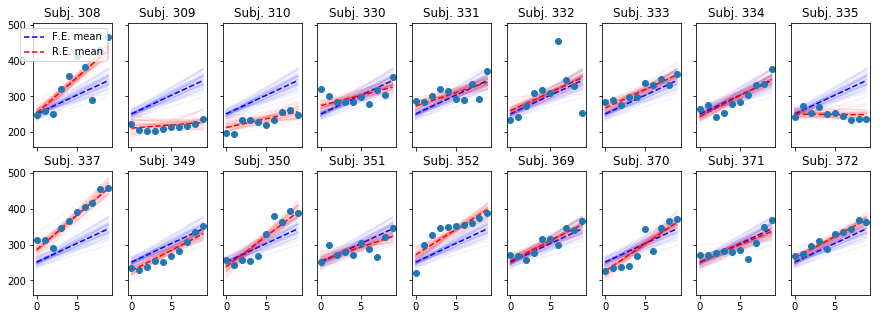

In [25]:
days = np.unique(sleep.Days)
subject_ids = np.unique(sleep.Subject)

fig, ax = plt.subplots(nrows=2, ncols=9, figsize=(15, 5), sharex=True, sharey=True)
ax = ax.ravel()

THIN = 500
# Main effect  
for i, subject in enumerate(subject_ids):
    for b0, b1 in zip(beta_intercept[::THIN], 
                      beta_slope[::THIN]):
        ax[i].plot(days, b0 + days*b1, '-b', alpha=0.05)
        ax[i].set_title('Subj. {}'.format(subject))

        
for i, subject in enumerate(subject_ids):
    ax[i].plot(days, beta_intercept.mean() + days*beta_slope.mean(), '--b',
              label='F.E. mean')
    
# Random effect
for i, subject in enumerate(subject_ids):
    for b0, b1, g0, g1 in zip(beta_intercept[::THIN], 
                  beta_slope[::THIN],
                  gamma_intercept[::THIN, i],
                  gamma_slope[::THIN, i]):
        ax[i].plot(days, (b0 + g0) + days * (b1 + g1), '-r', alpha=0.05)

for i, subject in enumerate(subject_ids):
    ax[i].plot(days,
               beta_intercept.mean() + gamma_intercept[:, i].mean() + 
               days * (beta_slope.mean() + gamma_slope[:, i].mean()), '--r', 
               label='R.E. mean')    
    

for i, subject in enumerate(subject_ids):
    ax[i].plot(days, sleep.Reaction[sleep.Subject==subject].values, 'o')
    

ax[0].legend();

In [26]:
corr_test = np.array(np.zeros(gamma_intercept.shape[0]))
#for i in np.arange(0, gamma_intercept.shape[0]):
#    corr_test[i] = np.corrcoef(gamma_intercept[i, :], gamma_slope[i, :])[0, 1]
    
for i in np.arange(0, gamma_intercept.shape[0]):
    cov = np.cov(np.stack((gamma_intercept[i, :], gamma_slope[i, :])))
    std = np.sqrt(np.diag(cov))
    corr_test[i] = np.diag(std**-1).dot(cov.dot(np.diag(std**-1)))[0, 1]

```cor_1[1]         0.09  0.3  -0.48  -0.13   0.08    0.3   0.68
```

In [27]:
np.mean(corr_test)

0.10120750806501694

In [28]:
np.std(corr_test)

0.22674785136786843

In [29]:
np.percentile(corr_test[BURNIN:], [2.5, 25, 50, 75, 97.5] )

array([-0.27929677, -0.06231669,  0.07884272,  0.24052273,  0.6155017 ])